# Class activation maps (CAM)
A class activation map shows which regions in the image are relevant to a specific class.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [3]:
PATH = "data/dogscats/"

In [4]:
sz = 224
arch = resnet34
bs = 64

In [5]:
model = arch(pretrained=True)

In [6]:
model = nn.Sequential(*children(model)[:-2], nn.Conv2d(in_channels=512, out_channels=2, kernel_size=3, padding=1), nn.AdaptiveMaxPool2d(1), Flatten(), nn.LogSoftmax())

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [8]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [9]:
learn = ConvLearner.from_model_data(model, data)

In [10]:
learn.freeze_to(-4)

In [14]:
print(model[-4].trainable, model[-5].trainable)

True False


In [15]:
learn.fit(lrs=0.01, n_cycle=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.159561   0.091193   0.984     



[array([0.09119]), 0.984]

In [20]:
learn.fit(lrs=0.01, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.095105   0.074668   0.986     



[array([0.07467]), 0.986]

## CAM

In [22]:
class SaveFeatures():
    features = None
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

In [26]:
x, y = next(iter(data.val_dl))

In [28]:
x, y = x[None, 1], y[None, 1]

In [30]:
vx = Variable(x.cuda(), requires_grad=True)

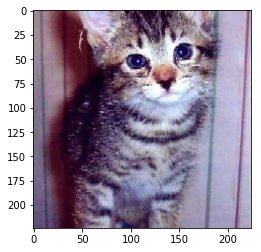

In [31]:
plt.imshow(data.val_ds.denorm(x)[0])

In [34]:
features = [SaveFeatures(o) for o in [model[-7], model[-6], model[-5], model[-4]]]

In [44]:
%time pred = model(vx)

CPU times: user 4.84 ms, sys: 8.48 ms, total: 13.3 ms
Wall time: 12.5 ms


In [45]:
for o in features:
    o.remove()  # removes the hook

In [46]:
[o.features.size() for o in features]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

`features[3]` contains the activations of the last convolutional layer. The first filter contains the activations that mark "cat-like" regions in the image, the second filter contains the activations that mark "dog-like" regions in the image.

In [48]:
pred = np.exp(pred.data.cpu().numpy()[0])

In [49]:
pred

array([1., 0.], dtype=float32)

Remove negative activations

In [59]:
feat = np.maximum(0, features[3].features[0].data.cpu().numpy())

In [ ]:
feat2 = np.dot()

In [78]:
feat2 = np.dot(np.rollaxis(a=feat, axis=0, start=3), pred)
feat2 -= feat2.min()
feat2 /= feat2.max()
# equivalent to .transpose(1,2,0)

/home/fabiograetz/anaconda3/envs/deeplearning_save_2/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


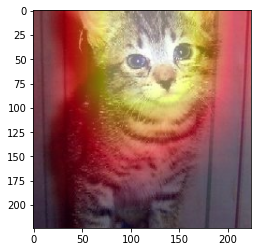

In [89]:
pic = data.val_ds.denorm(x)[0]
plt.imshow(pic)
plt.imshow(scipy.misc.imresize(feat2, pic.shape), alpha=0.5, cmap='hot')